## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


In [ ]:
pip install odc-geo --quiet

In [ ]:
pip install git+https://github.com/digitalearthafrica/deafrica-coastlines.git --quiet

### Load packages

In [2]:
%load_ext autoreload
%autoreload 2

import datacube
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from datacube.utils.geometry import GeoBox, Geometry
from odc.algo import mask_cleanup
import odc.geo.xr

from dea_tools.dask import create_local_dask_cluster, create_dask_gateway_cluster
from dea_tools.datahandling import mostcommon_crs
from dea_tools.bandindices import calculate_indices
from dea_tools.spatial import subpixel_contours, interpolate_2d, contours_to_arrays
from dea_tools.coastal import tidal_tag

from coastlines.raster import model_tides
from intertidal.extents import load_data


def create_dask_gateway_cluster(profile="r5_L", workers=2):
    """
    Create a cluster in our internal dask cluster.
    Parameters
    ----------
    profile : str
        Possible values are:
            - r5_L (2 cores, 15GB memory)
            - r5_XL (4 cores, 31GB memory)
            - r5_2XL (8 cores, 63GB memory)
            - r5_4XL (16 cores, 127GB memory)
    workers : int
        Number of workers in the cluster.
    """        
    
    try:
        
        from dask_gateway import Gateway
        gateway = Gateway()

        # Close any existing clusters
        if len(cluster_names) > 0:
            print("Cluster(s) still running:", cluster_names)
            for n in cluster_names:
                cluster = gateway.connect(n.name)
                cluster.shutdown()

        # Connect to new cluster
        options = gateway.cluster_options()
        options["profile"] = profile
        options["jupyterhub_user"] = "robbi"
        cluster = gateway.new_cluster(options)
        cluster.scale(workers)

        return cluster

    except ClientConnectionError:
        raise ConnectionError("Access to dask gateway cluster unauthorized")

# cluster = create_dask_gateway_cluster(profile="r5_4XL", workers=10)
# print("Dashboard", cluster.dashboard_link)
# client = cluster.get_client()

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 94,Total memory: 697.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40485,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 94
Started: Just now,Total memory: 697.21 GiB
Comm: tcp://127.0.0.1:36617,Total threads: 94
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/44149/status,Memory: 697.21 GiB
Nanny: tcp://127.0.0.1:42501,


## Setup

In [3]:
dc = datacube.Datacube(app='Intertidal_elevation')

In [ ]:
# aoi = 'Wollogorang'
# aoi = 'McCarthur River'
# aoi = 'Greenbank'
aoi = 'Seven Emu'

# Import regions of interest
aoi_gdf = gpd.read_file('data/raw/Phase_1_NT_Gov.geojson').set_index('Name').to_crs('EPSG:3577')
aoi_gdf.head()

# Select AOI
geom = Geometry(geom=aoi_gdf.loc[aoi].geometry, crs='EPSG:3577')
geom

In [4]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4)

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Load data

In [153]:
ds = load_data(dc=dc, 
               geom=geom, 
               time_range=('2019', '2021'), 
               resolution=10)
ds

<xarray.Dataset>
Dimensions:      (time: 315, y: 210, x: 266)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-03T00:48:15.730294 ... 2021-12...
  * y            (y) float64 8.217e+06 8.217e+06 ... 8.215e+06 8.215e+06
  * x            (x) float64 7.538e+05 7.538e+05 ... 7.564e+05 7.564e+05
    spatial_ref  int32 32753
Data variables:
    ndwi         (time, y, x) float32 dask.array<chunksize=(1, 210, 266), meta=np.ndarray>
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref

## Pixel-based tides

In [154]:
# Create a new 5km-res tide modelling grid after first
# buffering the grid by 12km (i.e. at least two 5km pixels)
rescaled_geobox = ds.odc.geobox.buffered(12000).zoom_out(500)
rescaled_ds = odc.geo.xr.xr_zeros(rescaled_geobox)

# Flatten grid to 1D, then add time dimension
flattened_ds = rescaled_ds.stack(z=("x", "y"))
flattened_ds = flattened_ds.expand_dims(dim={"time": ds.coords["time"].values})

In [155]:
# Model tides for each time and grid cell
tide_df = model_tides(
    x=flattened_ds.x,
    y=flattened_ds.y,
    time=flattened_ds.time,
    directory="~/tide_models",
    epsg=ds.odc.geobox.crs.epsg,
)

In [156]:
# Insert modelled tide values back into flattened array, then unstack
# back to 3D (x, y, time)
tides_ds = (
    flattened_ds.groupby("time")
    .apply(lambda x: tide_df.loc[str(x.time.values)].tide_m.values)
    .unstack("z")
    .T
    .astype(np.float32)
)

In [157]:
from coastlines.raster import multiprocess_apply

def simple(x):
    return x.odc.reproject(ds.odc.geobox, resampling='cubic')

# Reproject each timestep into higher resolution, and add as new variable
ds['tide_m'] = multiprocess_apply(tides_ds, dim='time', func=simple)


<AxesSubplot:title={'center':'time = 2019-03-16T00:52:41.112459, spatial_ref ...'}, xlabel='x', ylabel='y'>

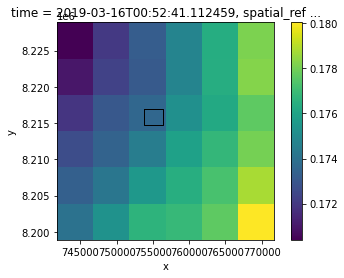

In [121]:
timestep = tides_ds.isel(time=20)
timestep.plot()
gpd.GeoSeries(ds.odc.geobox.footprint(crs='EPSG:32753').geom).plot(ax=plt.gca(), vmin=timestep.min(), vmax=timestep.max(), color='none')

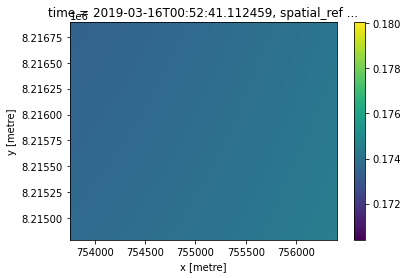

In [122]:
ds['tide_m'].isel(time=20).plot(vmin=timestep.min(), vmax=timestep.max())

In [158]:
ds.load()

<xarray.Dataset>
Dimensions:      (time: 315, y: 210, x: 266)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-03T00:48:15.730294 ... 2021-12...
  * y            (y) float64 8.217e+06 8.217e+06 ... 8.215e+06 8.215e+06
  * x            (x) float64 7.538e+05 7.538e+05 ... 7.564e+05 7.564e+05
    spatial_ref  int32 32753
Data variables:
    ndwi         (time, y, x) float32 0.4774 0.4877 0.4985 ... nan nan nan
    tide_m       (time, y, x) float32 -0.04913 -0.04913 ... 0.04201 0.04201
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref

### Special sorting

In [163]:
def pixel_tide_sort(ds, tide_var="tide_m", ndwi_var="ndwi", tide_dim="tide_n"):

    # Return indicies to sort each pixel by tide along time dim
    sort_indices = np.argsort(ds[tide_var].values, axis=0)

    # Use indices to sort both tide and NDWI array
    tide_sorted = np.take_along_axis(ds[tide_var].values, sort_indices, axis=0)
    ndwi_sorted = np.take_along_axis(ds[ndwi_var].values, sort_indices, axis=0)

    # Update values in array
    ds[tide_var][:] = tide_sorted
    ds[ndwi_var][:] = ndwi_sorted

    return (
        ds.assign_coords(coords={tide_dim: ("time", range(len(ds.time)))})
        .swap_dims({"time": tide_dim})
        .drop("time")
    )

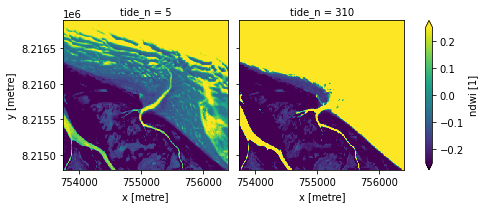

In [175]:
ds = pixel_tide_sort(ds, tide_var='tide_m', ndwi_var='ndwi', tide_dim='tide_n')
ds.isel(tide_n=[5, -5]).ndwi.plot.imshow(col='tide_n', vmin=-0.25, vmax=0.25)

In [73]:
# plt.imshow(ndwi_sorted[-150,:,:])

In [74]:
# tide_sort = ds.tide_m.argsort(axis=0)

In [ ]:
# ds['tide_m'].values[tide_Args, :, :]

In [ ]:
# ds.tide_m.iloc[tide_sort]

# ds.tide_m[tide_sort]

In [ ]:
# time = times.values[200]

# timestep = reprojected_ds.sel(time=str(time))
# timestep.plot.imshow()
# gpd.GeoDataFrame(tide_df.loc[time].tide_m, 
#                  geometry=gpd.points_from_xy(tide_df.loc[time].x, 
#                                              tide_df.loc[time].y, 
#                                              crs='EPSG:4326')).to_crs(ds.odc.geobox.crs).plot(
#     column='tide_m', cmap='viridis', ax=plt.gca(), edgecolor='black', 
#     vmin=timestep.min(), 
#     vmax=timestep.max())

## Load into memory

In [ ]:
# ds.load()

In [180]:
ds_rolling = ds.ndwi.rolling(tide_n=100, min_periods=10, center=True)
s2_median = ds_rolling.median()
s2_stdev = ds_rolling.std()
s2_stdev_mean = s2_stdev.mean(dim='tide_n')

In [97]:
# s2_median.isel(tide_height=300.plot()

In [181]:
# Output name
fname = 'testing'
# fname = aoi.lower().replace(' ', '')

# Calculate 
min_thresh = (0 - 0.5 * s2_stdev_mean)
max_thresh = (0 + 0.5 * s2_stdev_mean)

for thresh_name, thesh in {'': 0, '_low': min_thresh, '_high': max_thresh}.items():
    
    dem_fname = f'pixel_dem_{fname}{thresh_name}.tif'
    print(f'Exporting {dem_fname}')
    
    # Identify the max tide per pixel where NDWI == land
    tide_thresh = ds.tide_m.where(s2_median <= thesh).max(dim='tide_n')
    tide_max = ds.tide_m.max(dim='tide_n')
    
    # Remove any pixel where tides max out (i.e. always land)
    dem = tide_thresh.where(tide_thresh < tide_max)
    
    # Export DEM file
    write_cog(dem, fname=dem_fname, overwrite=True)  

# Export NDWI standard deviation/confidence file
write_cog(s2_stdev_mean, fname=f'pixel_dem_{fname}_confidence.tif', overwrite=True)  

Exporting pixel_dem_testing.tif
Exporting pixel_dem_testing_low.tif
Exporting pixel_dem_testing_high.tif


PosixPath('pixel_dem_testing_confidence.tif')

In [ ]:
from dea_tools.temporal import lag_linregress_3D

In [ ]:
# reg = lag_linregress_3D(s2_rolling.tide_height, (s2_rolling > 0).where(~s2_rolling.isnull()), first_dim='tide_height')
# (reg.pval < 0.01).plot.imshow()

In [ ]:
# s2_rolling

In [ ]:
# test_min = tide_3d.where(s2_rolling >= 0).min(dim='tide_height')
# test_max = tide_3d.where(s2_rolling < 0).max(dim='tide_height')
# # dem = test_min.where(~test_max.isnull())
# dem = ((test_max + test_min) / 2.0)
# write_cog(dem, fname='pixel_dem_mccarthurriver.tif', overwrite=True)


In [ ]:
# out = xr.corr(s2_rolling, tide_3d)

In [ ]:
write_cog(test_max, fname='pixel_dem13.tif', overwrite=True)  # 

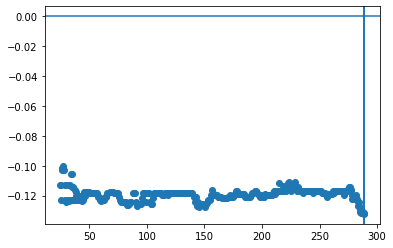

In [87]:
x, y = 755234.5430086093, 8215882.783825266
# pixel = s2_rolling.sel(x=x,  y=y, method='nearest')
# df_median = pixel.to_dataframe()[['ndwi']].reset_index()

pixel = ds.sel(x=x,  y=y, method='nearest')
df = pixel.to_dataframe()[['ndwi']].reset_index()
df_median = df.rolling(100, min_periods=10, center=True).median()
df_std = df.rolling(100, min_periods=10, center=True).std()
std_mean = df_std.ndwi.mean()

fig, ax = plt.subplots(1, 1)
ax.scatter(x=df_median.tide_height, y=df_median.ndwi)
# ax.axvline(df_median.where(df_median.ndwi > 0).tide_height.min())
ax.axvline(df_median.where(df_median.ndwi < 0).tide_height.max())
ax.axvline(df_median.where(df_median.ndwi < (0 + std_mean * 0.5)).tide_height.max())
ax.axvline(df_median.where(df_median.ndwi < (0 - std_mean * 0.5)).tide_height.max())
ax.axhline(0)

In [ ]:
std_mean.ndwi

In [ ]:
df_median.where(df_median.ndwi < 0).tide_height.max()

In [ ]:
df_median.where(df_median.ndwi > 0).tide_height.min()

# Shut down cluster

In [ ]:
from dask_gateway import Gateway
gateway = Gateway()

# Close any existing clusters
cluster_names = gateway.list_clusters()
if len(cluster_names) > 0:
    print("Cluster(s) still running:", cluster_names)
    for n in cluster_names:
        cluster = gateway.connect(n.name)
        cluster.shutdown()

In [ ]:
cluster.shutdown()